# Airline Passenger Satisfaction

In [11]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import chi2_contingency

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from scipy.stats import iqr
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

import pickle

 

This dataset is a survey on airline passengers satisfaction levels and has been downloaded from the Kaggle website. The data set can be found at the following link: https://www.kaggle.com/datasets/teejmahal20/airline-passenger-satisfaction/data.  It contains 24 features, most of which are categorical in nature. The response variable 'satisfaction' is binary. The goal is to understand which factors have the greatest effect on customer satisfaction and to classify new customers into the satisfied or dissatisfied group.  

In [14]:
train = pd.read_csv('../Data/Raw/train.csv')
train.head()

,Unnamed: 0,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,...,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,1,5047,Male,disloyal Customer,25,Business travel,Business,235,3,2,...,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,2,110028,Female,Loyal Customer,26,Business travel,Business,1142,2,2,...,5,4,3,4,4,4,5,0,0.0,satisfied
3,3,24026,Female,Loyal Customer,25,Business travel,Business,562,2,5,...,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,4,119299,Male,Loyal Customer,61,Business travel,Business,214,3,3,...,3,3,4,4,3,3,3,0,0.0,satisfied


## EDA

### Cleaning the Data Set

First, the data set is checked to see whether each column is correctly formatted. 

In [2972]:
# Checking for missing values:
print(train.info())

<class 'pandas.core.frame.DataFrame'>
Index: 103904 entries, 0 to 103903
Data columns (total 24 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   id                                 103904 non-null  int64  
 1   Gender                             103904 non-null  object 
 2   Customer Type                      103904 non-null  object 
 3   Age                                103904 non-null  int64  
 4   Type of Travel                     103904 non-null  object 
 5   Class                              103904 non-null  object 
 6   Flight Distance                    103904 non-null  int64  
 7   Inflight wifi service              103904 non-null  int64  
 8   Departure/Arrival time convenient  103904 non-null  int64  
 9   Ease of Online booking             103904 non-null  int64  
 10  Gate location                      103904 non-null  int64  
 11  Food and drink                     103904 no

There appear to be no explicit missing values. However, in the description of the data, categorical variables which contain a category numbered '0' are 'unapplicable' and will be considered as missing. 

In [2973]:
# Checking whether the `id` column has only unique values:
len(train['id'].unique())

103904

In [2974]:
# Unique column values:
train['Gender'].unique()
# Covert to categorical:
train['Gender'] = train['Gender'].astype('category')
train['Gender'].unique()

['Male', 'Female']
Categories (2, object): ['Female', 'Male']

In [2975]:
# Unique column values:
train['Customer Type'].unique()
# Format the column:
train['Customer Type'] = train['Customer Type'].str.capitalize()
# Covert to categorical:
train['Customer Type'] = train['Customer Type'].astype('category')
train['Customer Type'].unique()

['Loyal customer', 'Disloyal customer']
Categories (2, object): ['Disloyal customer', 'Loyal customer']

In [2976]:
# Unique column values:
train['Age'].unique()
# Validating data:
print('Minimum Age:', train['Age'].min())
print('Maximum Age:', train['Age'].max())

Minimum Age: 7
Maximum Age: 85


In [2977]:
# Unique column values:
train['Type of Travel'].unique()
# Capitalise the info:
train['Type of Travel'] = train['Type of Travel'].str.capitalize()
# Covert to categorical:
train['Type of Travel'] = train['Type of Travel'].astype('category')
train['Type of Travel'].unique()

['Personal travel', 'Business travel']
Categories (2, object): ['Business travel', 'Personal travel']

In [2978]:
# Unique column values:
train['Class'].unique()
train['Class'] = train['Class'].str.replace('Eco', '1')
train['Class'] = train['Class'].str.replace('1 Plus', '2')
train['Class'] = train['Class'].str.replace('Business', '3')
# Convert to categorical:
train['Class'] = train['Class'].astype('category')
train['Class'] = train['Class'].cat.set_categories(new_categories = ['1', '2', '3'], ordered = True)
train['Class'].unique()

['2', '3', '1']
Categories (3, object): ['1' < '2' < '3']

In [2979]:
# Unique column values:
train['Flight Distance'].unique()
# Validating data:
print('Minimum Flight Distance:', train['Flight Distance'].min())
print('Maximum Flight Distance:', train['Flight Distance'].max())

Minimum Flight Distance: 31
Maximum Flight Distance: 4983


In [2980]:
# Unique column values:
train['Inflight wifi service'].unique()
# Convert to ordered categorical:
train['Inflight wifi service'] = train['Inflight wifi service'].astype('category')
train['Inflight wifi service'] = train['Inflight wifi service'].cat.set_categories(new_categories = [1, 2, 3, 4, 5], ordered = True)
train['Inflight wifi service'].unique()

[3, 2, 4, 1, 5, NaN]
Categories (5, int64): [1 < 2 < 3 < 4 < 5]

In [2981]:
# Unique column values:
train['Departure/Arrival time convenient'].unique()
# Convert to ordered categorical:
train['Departure/Arrival time convenient'] = train['Departure/Arrival time convenient'].astype('category')
train['Departure/Arrival time convenient'] = train['Departure/Arrival time convenient'].cat.set_categories(new_categories = [1, 2, 3, 4, 5],
                                                                                                           ordered = True)
train['Departure/Arrival time convenient'].unique()

[4, 2, 5, 3, 1, NaN]
Categories (5, int64): [1 < 2 < 3 < 4 < 5]

In [2982]:
# Unique column values:
train['Ease of Online booking'].unique()
# Convert to ordered categorical:
train['Ease of Online booking'] = train['Ease of Online booking'].astype('category')
train['Ease of Online booking'] = train['Ease of Online booking'].cat.set_categories(new_categories = [1, 2, 3, 4, 5], 
                                                                                     ordered = True)
train['Ease of Online booking'].unique()

[3, 2, 5, 4, 1, NaN]
Categories (5, int64): [1 < 2 < 3 < 4 < 5]

In [2983]:
# Unique column values:
train['Gate location'].unique()
# Convert to ordered categorical:
train['Gate location'] = train['Gate location'].astype('category')
train['Gate location'] = train['Gate location'].cat.set_categories(new_categories = [1, 2, 3, 4, 5], ordered = True)
train['Gate location'].unique()

[1, 3, 2, 5, 4, NaN]
Categories (5, int64): [1 < 2 < 3 < 4 < 5]

In [2984]:
# Unique column values:
train['Food and drink'].unique()
# Convert to ordered categorical:
train['Food and drink'] = train['Food and drink'].astype('category')
train['Food and drink'] = train['Food and drink'].cat.set_categories(new_categories = [1, 2, 3, 4, 5], ordered = True)
train['Food and drink'].unique()

[5, 1, 2, 4, 3, NaN]
Categories (5, int64): [1 < 2 < 3 < 4 < 5]

In [2985]:
# Unique column values:
train['Online boarding'].unique()
# Convert to ordered categorical:
train['Online boarding'] = train['Online boarding'].astype('category')
train['Online boarding'] = train['Online boarding'].cat.set_categories(new_categories = [1, 2, 3, 4, 5], ordered = True)
train['Online boarding'].unique()

[3, 5, 2, 1, 4, NaN]
Categories (5, int64): [1 < 2 < 3 < 4 < 5]

In [2986]:
# Unique column values:
train['Seat comfort'].unique()
# Convert to ordred categorical:
train['Seat comfort'] = train['Seat comfort'].astype('category')
train['Seat comfort'] = train['Seat comfort'].cat.set_categories(new_categories = [1, 2, 3, 4, 5], ordered = True)
train['Seat comfort'].unique()


[5, 1, 2, 3, 4, NaN]
Categories (5, int64): [1 < 2 < 3 < 4 < 5]

In [2987]:
# Unique column values:
train['Inflight entertainment'].unique()
# Convert to ordered categorical:
train['Inflight entertainment'] = train['Inflight entertainment'].astype('category')
train['Inflight entertainment'] = train['Inflight entertainment'].cat.set_categories(new_categories = [1, 2, 3, 4, 5], ordered = True)
train['Inflight entertainment'].unique()

[5, 1, 2, 3, 4, NaN]
Categories (5, int64): [1 < 2 < 3 < 4 < 5]

In [2988]:
# Unique column values:
train['On-board service'].unique()
# Convert to ordered categorical:
train['On-board service'] = train['On-board service'].astype('category')
train['On-board service'] = train['On-board service'].cat.set_categories(new_categories = [1, 2, 3, 4, 5], ordered = True)
train['On-board service'].unique()


[4, 1, 2, 3, 5, NaN]
Categories (5, int64): [1 < 2 < 3 < 4 < 5]

In [2989]:
# Unique column values:
train['Leg room service'].unique()
# Convert to ordered categorical:
train['Leg room service'] = train['Leg room service'].astype('category')
train['Leg room service'] = train['Leg room service'].cat.set_categories(new_categories = [1, 2, 3, 4, 5], ordered = True)
train['Leg room service'].unique()

[3, 5, 4, 2, 1, NaN]
Categories (5, int64): [1 < 2 < 3 < 4 < 5]

In [2990]:
# Unique column values:
train['Baggage handling'].unique()
# Convert to ordered categorical:
train['Baggage handling'] = train['Baggage handling'].astype('category')
train['Baggage handling'] = train['Baggage handling'].cat.set_categories(new_categories = [1, 2, 3, 4, 5], ordered = True)
train['Baggage handling'].unique()


[4, 3, 5, 1, 2]
Categories (5, int64): [1 < 2 < 3 < 4 < 5]

In [2991]:
# Unique column values:
train['Checkin service'].unique()
# Convert to ordered categorical:
train['Checkin service'] = train['Checkin service'].astype('category')
train['Checkin service'] = train['Checkin service'].cat.set_categories(new_categories = [1, 2, 3, 4, 5], ordered = True)
train['Checkin service'].unique()

[4, 1, 3, 5, 2, NaN]
Categories (5, int64): [1 < 2 < 3 < 4 < 5]

In [2992]:
# Unique column values:
train['Inflight service'].unique()
# Convert to cordered ategorical:
train['Inflight service'] = train['Inflight service'].astype('category')
train['Inflight service'] = train['Inflight service'].cat.set_categories(new_categories = [1, 2, 3, 4, 5], ordered = True)
train['Inflight service'].unique()

[5, 4, 3, 1, 2, NaN]
Categories (5, int64): [1 < 2 < 3 < 4 < 5]

In [2993]:
# Unique column values:
train['Cleanliness'].unique()
# Convert to ordered categorical:
train['Cleanliness'] = train['Cleanliness'].astype('category')
train['Cleanliness'] = train['Cleanliness'].cat.set_categories(new_categories = [1, 2, 3, 4, 5], ordered = True)
train['Cleanliness'].unique()

[5, 1, 2, 3, 4, NaN]
Categories (5, int64): [1 < 2 < 3 < 4 < 5]

In [2994]:
# Unique column values:
print(train['Departure Delay in Minutes'].unique()[0:100])
# Check column dtype:
print('Dtype:', train['Departure Delay in Minutes'].dtype)
# Validating data:
print('Minimum Departure Delay in Minutes:', train['Departure Delay in Minutes'].min())
print('Maximum Departure Delay in Minutes:',train['Departure Delay in Minutes'].max())

[ 25   1   0  11   9   4  28  43  49   7  17  52  54  27  18  19   3 109
  23   8  14  10  51  39  13  30  64  20  45  44  31  81  35  67  22  40
  91  21  15  29 105  12 162  24 141   6  34   2  97  16  99  37  66  53
  36 209  60 149  26   5  59  62 113  38  83 176  46  73 199  56  93  70
  80  96  57  95  74 172  63 175 143  48  47 101 118  76 220  33  55 232
 170 173 124 112  94 243 128  92 270  90]
Dtype: int64
Minimum Departure Delay in Minutes: 0
Maximum Departure Delay in Minutes: 1592


In [2995]:
# Unique column values:
print(train['Arrival Delay in Minutes'].unique()[0:100])
# Check column dtype:
print('Dtype:', train['Arrival Delay in Minutes'].dtype)
# Validating data:
print('Minimum Arrival Delay in Minutes:', train['Arrival Delay in Minutes'].min())
print('Maximum Arrival Delay in Minutes:', train['Arrival Delay in Minutes'].max())

[ 18.   6.   0.   9.  23.   8.  35.  51.  10.   5.   4.  29.  44.  28.
  12. 120.  24.   1.  20.  31.  15.  48.  26.  49.   2.  37.  50.   3.
  19.  72.  11.  34.  62.  27.  52.  13.  82.  30.  16.   7. 122. 179.
 125.  17.  nan  89. 101.  14.  61.  32.  33.  41. 191. 138.  53.  22.
  57.  65.  76. 107.  92. 164.  21.  40.  55. 185.  63.  77.  86.  91.
 100.  54.  36.  70. 139.  67. 163. 128. 180.  93. 121.  45. 105. 126.
  56.  73. 212.  88. 241. 172. 175. 111.  99.  25.  42. 226.  46. 131.
 260.  69.]
Dtype: float64
Minimum Arrival Delay in Minutes: 0.0
Maximum Arrival Delay in Minutes: 1584.0


In [2996]:
# Unique column values:
print(train['satisfaction'].unique())

# Format column name:
train = train.rename(columns = {'satisfaction': 'Satisfaction'})
train['Satisfaction'].unique()

change = {'satisfied': 1, 'neutral or dissatisfied': 2}
train['Satisfaction'] = train['Satisfaction'].replace(change)
train['Satisfaction'] = train['Satisfaction'].astype('int')

# Convert to ordered categorical:
train['Satisfaction'] = train['Satisfaction'].astype('category')
train['Satisfaction'] = train['Satisfaction'].cat.set_categories(new_categories = [1, 2], ordered = True)

['neutral or dissatisfied' 'satisfied']


/var/folders/1z/2qtxqpxj07g0pvc7h463fm_w0000gn/T/ipykernel_38175/720273769.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train['Satisfaction'] = train['Satisfaction'].replace(change)


In [2997]:
# Format column name:
train = train.rename(columns = {'Inflight wifi service': 'Inflight Wifi Service', 'Departure/Arrival time convenient': 'Departure/Arrival Time Convenient',
                                'Ease of Online booking': 'Ease of Online Booking', 'Gate location': 'Gate Location', 
                                'Food and drink': 'Food and Drink', 'Online boarding': 'Online Boarding', 'Seat comfort': 'Seat Comfort',
                                'Inflight entertainment': 'Inflight Entertainment', 'On-board service': 'On-board Service', 'Leg room service': 'Leg Room Service',
                                'Baggage handling': 'Baggage Handling', 'Checkin service': 'Checkin Service', 'Inflight service': 'Inflight Service'})


Notice how, when cleaning the data and setting correct ordered category values, a large number of NaNs were created. This will be further analysed below:

In [2998]:
train.isna().sum()

id                                      0
Gender                                  0
Customer Type                           0
Age                                     0
Type of Travel                          0
Class                                   0
Flight Distance                         0
Inflight Wifi Service                3103
Departure/Arrival Time Convenient    5300
Ease of Online Booking               4487
Gate Location                           1
Food and Drink                        107
Online Boarding                      2428
Seat Comfort                            1
Inflight Entertainment                 14
On-board Service                        3
Leg Room Service                      472
Baggage Handling                        0
Checkin Service                         1
Inflight Service                        3
Cleanliness                            12
Departure Delay in Minutes              0
Arrival Delay in Minutes              310
Satisfaction                      

We will drop NaN for variables with less than 5% of missing values:

In [2999]:
threshold = len(train)*0.05
print(round(threshold))

5195


In [3000]:
columns_to_drop = train.columns[train.isna().sum() <= threshold]
print(columns_to_drop)

Index(['id', 'Gender', 'Customer Type', 'Age', 'Type of Travel', 'Class',
       'Flight Distance', 'Inflight Wifi Service', 'Ease of Online Booking',
       'Gate Location', 'Food and Drink', 'Online Boarding', 'Seat Comfort',
       'Inflight Entertainment', 'On-board Service', 'Leg Room Service',
       'Baggage Handling', 'Checkin Service', 'Inflight Service',
       'Cleanliness', 'Departure Delay in Minutes', 'Arrival Delay in Minutes',
       'Satisfaction'],
      dtype='object')


In [3001]:
train.dropna(subset = columns_to_drop, inplace = True)
train.shape

(98860, 24)

One feature contains more missing values than the established threshold. Since the feature is categorical, the mode (most frequent category) will be used to impute the missing values. 

In [3002]:
# Computing the mode:
print('Mode:', train['Departure/Arrival Time Convenient'].mode())

# Converting the feature to a string dtype for imputation:
train['Departure/Arrival Time Convenient'] = train['Departure/Arrival Time Convenient'].astype('string')

# Filling missing values with the most frequent category:
train['Departure/Arrival Time Convenient'] = train['Departure/Arrival Time Convenient'].fillna('4.0')

# Converting the feature to categorical:
train['Departure/Arrival Time Convenient'] = train['Departure/Arrival Time Convenient'].astype('category')

# Reformatting the categories:
update_cats = {'4.0': '4', '2.0': '2', '5.0': '5', '3.0': '3', '1.0': '1'}
train['Departure/Arrival Time Convenient'] = train['Departure/Arrival Time Convenient'].replace(update_cats)

# Setting new categories:
train['Departure/Arrival Time Convenient'] = train['Departure/Arrival Time Convenient'].cat.set_categories(new_categories = ['1', '2', '3', '4', '5'], ordered = True)
train['Departure/Arrival Time Convenient'].unique()


Mode: 0    4
Name: Departure/Arrival Time Convenient, dtype: category
Categories (5, int64): [1 < 2 < 3 < 4 < 5]


/var/folders/1z/2qtxqpxj07g0pvc7h463fm_w0000gn/T/ipykernel_38175/562092237.py:15: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  train['Departure/Arrival Time Convenient'] = train['Departure/Arrival Time Convenient'].replace(update_cats)


['4', '2', '5', '3', '1']
Categories (5, object): ['1' < '2' < '3' < '4' < '5']

### Understanding the Data through Visualisations and Statistical Tests

#### Pairsplot

In [3003]:
# Select numerical data:
train.select_dtypes('number').head()

,id,Age,Flight Distance,Departure Delay in Minutes,Arrival Delay in Minutes
0,70172,13,460,25,18.0
1,5047,25,235,1,6.0
2,110028,26,1142,0,0.0
3,24026,25,562,11,9.0
4,119299,61,214,0,0.0


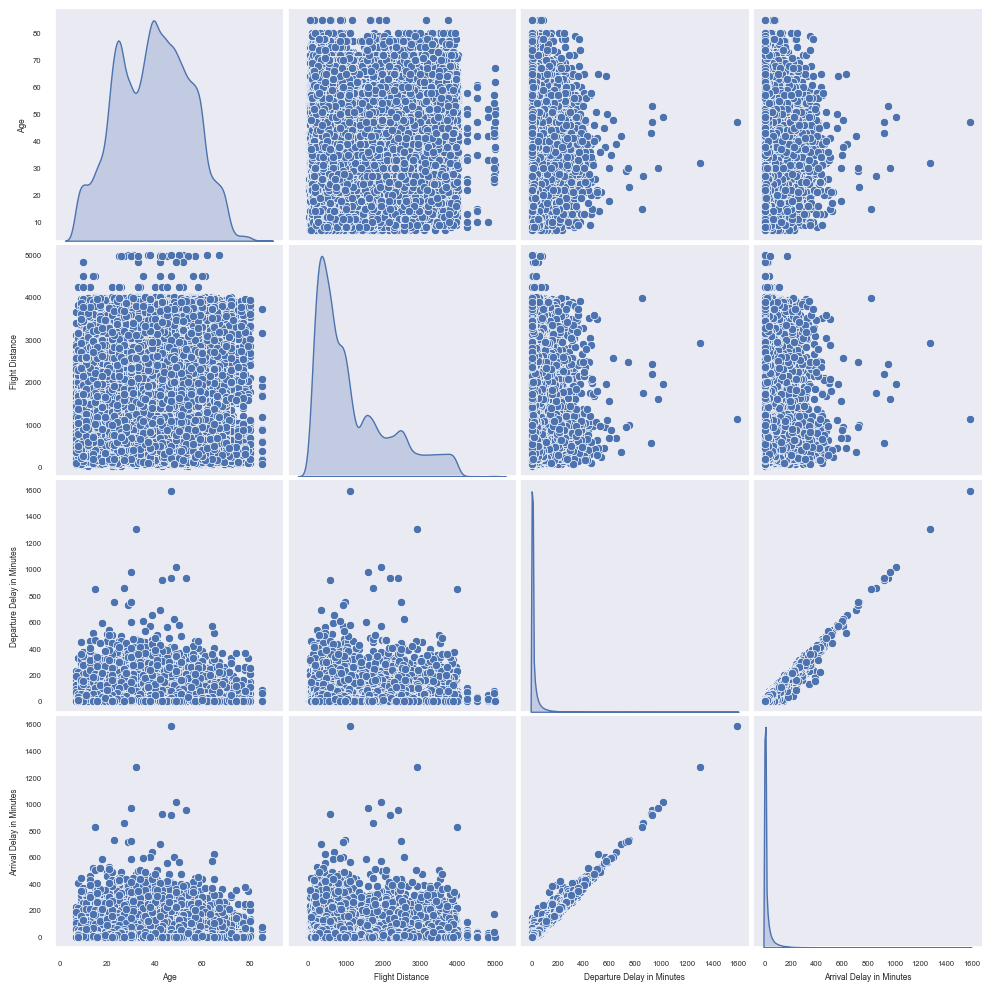

In [3004]:
sns.pairplot(data = train, vars = ['Age', 'Flight Distance', 'Departure Delay in Minutes', 'Arrival Delay in Minutes'], 
             diag_kind = 'kde')
plt.show()

The pairs plot does not seem to provide very useful information. The relationships presented are all quite expected. 

#### Heatmaps

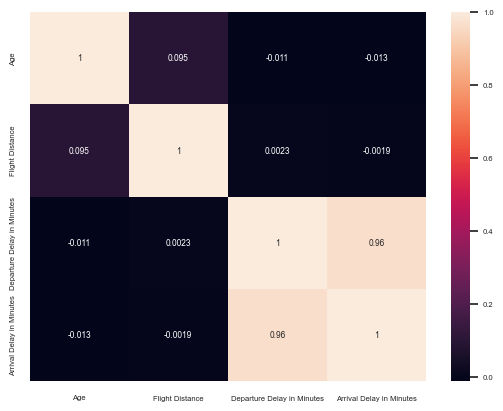

In [3005]:
train_corr = train.drop(['id', 'Gender', 'Customer Type', 'Type of Travel', 'Class', 
                                 'Inflight Wifi Service',
       'Departure/Arrival Time Convenient', 'Ease of Online Booking',
       'Gate Location', 'Food and Drink', 'Online Boarding', 'Seat Comfort',
       'Inflight Entertainment', 'On-board Service', 'Leg Room Service',
       'Baggage Handling', 'Checkin Service', 'Inflight Service',
       'Cleanliness',
       'Satisfaction'], axis = 1)
train_corr.corr()

sns.heatmap(train_corr.corr(), annot = True)
plt.show()

Similarly, the correlation heatmap for the numerical features does not present any surprising relationships. As expected departure delay is highly correlated with arrival delay. 

In [3006]:
train_corr_cat = train.drop(['id', 'Gender', 'Customer Type', 'Type of Travel'], axis = 1)

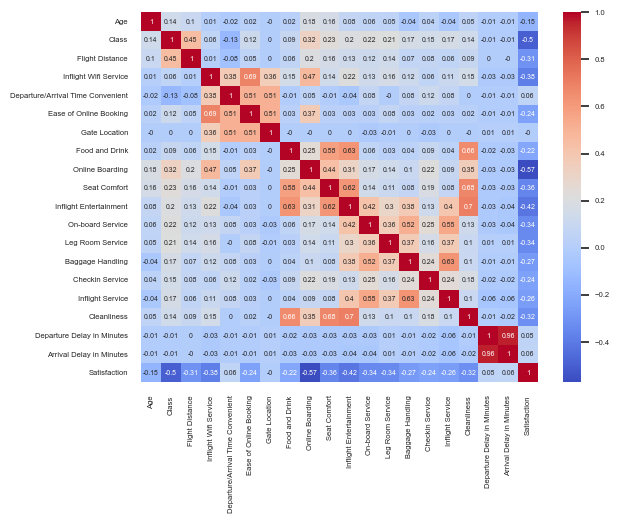

In [3007]:
sns.set(font_scale = 0.5)
sns.heatmap(round(train_corr_cat.corr(), 2), annot = True, cmap = 'coolwarm', annot_kws = {'size': 5})
plt.show()

It was possible to create the heatmap above since most categorical features in the dataset are ordinal. It can be seen that many of the features are correlated with eachother. However, none seem to be strongly correlated with the response variable `Satisfaction`. 

#### Chi-Squared Test for Nominal Features

$H_0$: there is no association between the two nominal variables tested below.

In [3008]:
contingency_table_1 = pd.crosstab(train['Gender'], train['Customer Type'])
print(contingency_table_1)

def chi_square_test(contingency_table):
    # chi-square test of association
    chi2_stat, p_val, dof, expected = chi2_contingency(contingency_table)

    print(f'Chi2-statistic: {chi2_stat}, P-value: {p_val}')

chi_square_test(contingency_table_1)

Customer Type  Disloyal customer  Loyal customer
Gender                                          
Female                      9714           40439
Male                        8272           40435
Chi2-statistic: 94.32006488441236, P-value: 2.684156205938696e-22


In [3009]:
contingency_table_2 = pd.crosstab(train['Gender'], train['Type of Travel'])
print(contingency_table_2)
chi_square_test(contingency_table_2)

Type of Travel  Business travel  Personal travel
Gender                                          
Female                    34938            15215
Male                      33627            15080
Chi2-statistic: 4.490022063483616, P-value: 0.03409323764013824


In [3010]:
contingency_table_4 = pd.crosstab(train['Customer Type'], train['Type of Travel'])
print(contingency_table_4)
chi_square_test(contingency_table_4)

Type of Travel     Business travel  Personal travel
Customer Type                                      
Disloyal customer            17835              151
Loyal customer               50730            30144
Chi2-statistic: 9187.67361983469, P-value: 0.0


The above chi-squared tests suggest that there is an association between the two nominal variables tested above. The p-values are all less than 0.05. 

### Histograms

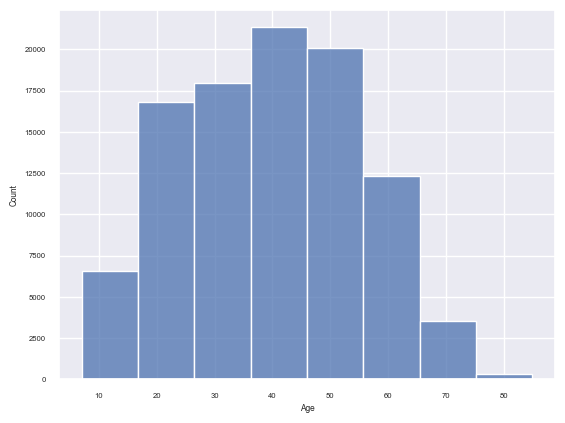

In [3011]:
sns.histplot(x = 'Age',  data = train, binwidth = 10)
plt.show()

The above histogram presents the distribution of the age of passengers surveyed.

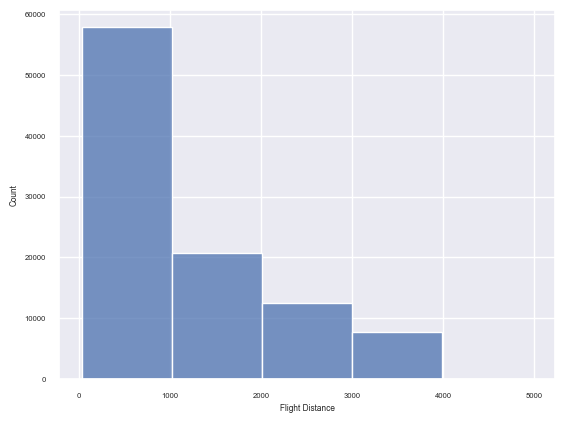

In [3012]:
sns.histplot(x = 'Flight Distance',  data = train, binwidth = 1000)
plt.show()

The plot clearly shows that there were substantially more short-haul flights than long-haul in this survey. 

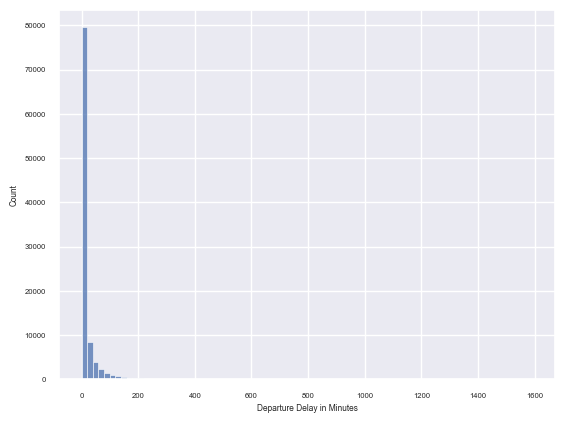

In [3013]:
sns.histplot(x = 'Departure Delay in Minutes',  data = train, binwidth = 20)
plt.show()

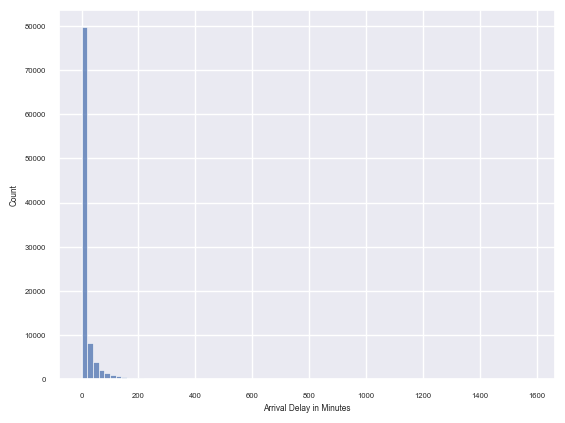

In [3014]:
sns.histplot(x = 'Arrival Delay in Minutes',  data = train, binwidth = 20)
plt.show()


Both plots above show that most delays were rather short.

#### Count Plots

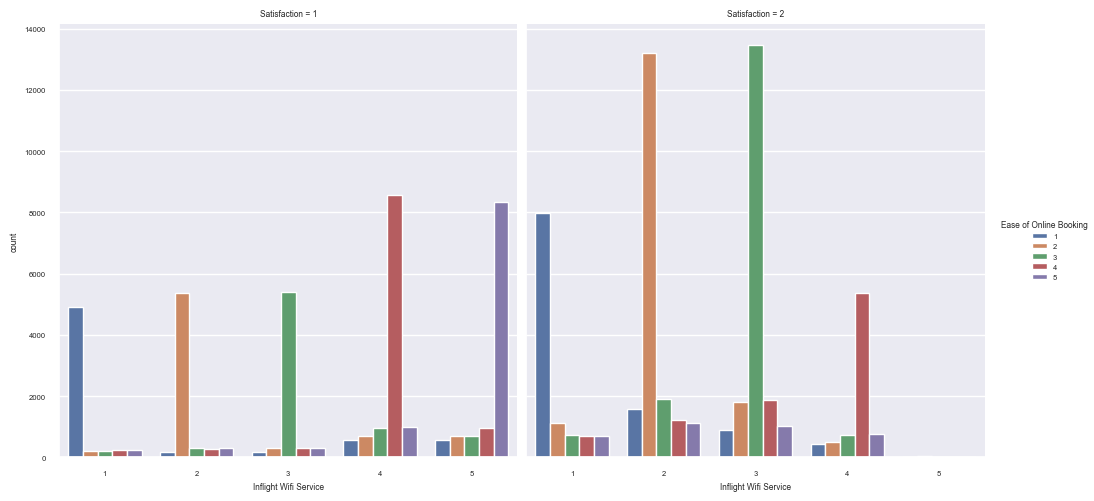

In [3015]:
sns.catplot(x = 'Inflight Wifi Service', hue = 'Ease of Online Booking', kind = 'count', col = 'Satisfaction',
             data = train)
plt.show()

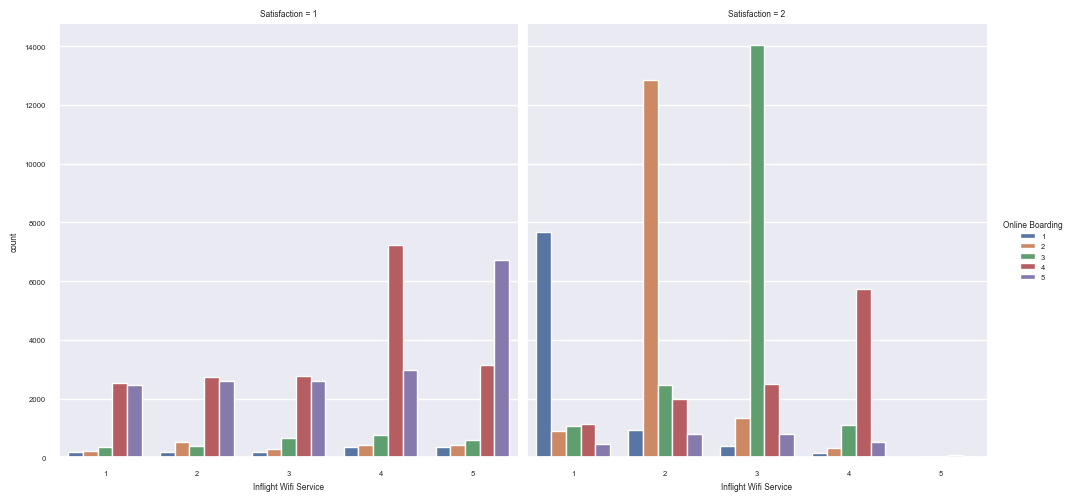

In [3016]:
sns.catplot(x = 'Inflight Wifi Service', hue = 'Online Boarding', kind = 'count', col = 'Satisfaction',
             data = train)
plt.show()

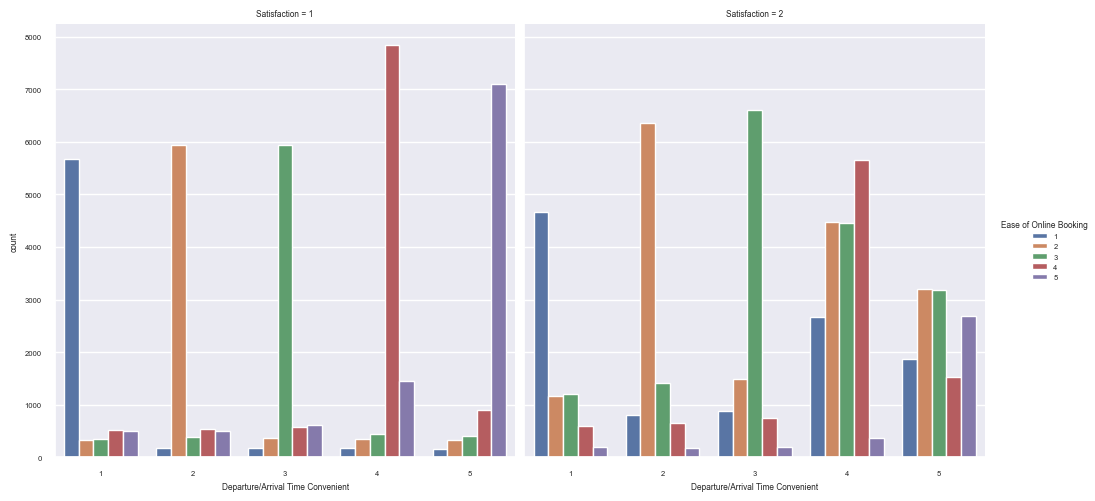

In [3017]:
sns.catplot(x = 'Departure/Arrival Time Convenient', hue = 'Ease of Online Booking', kind = 'count', col = 'Satisfaction',
             data = train)
plt.show()

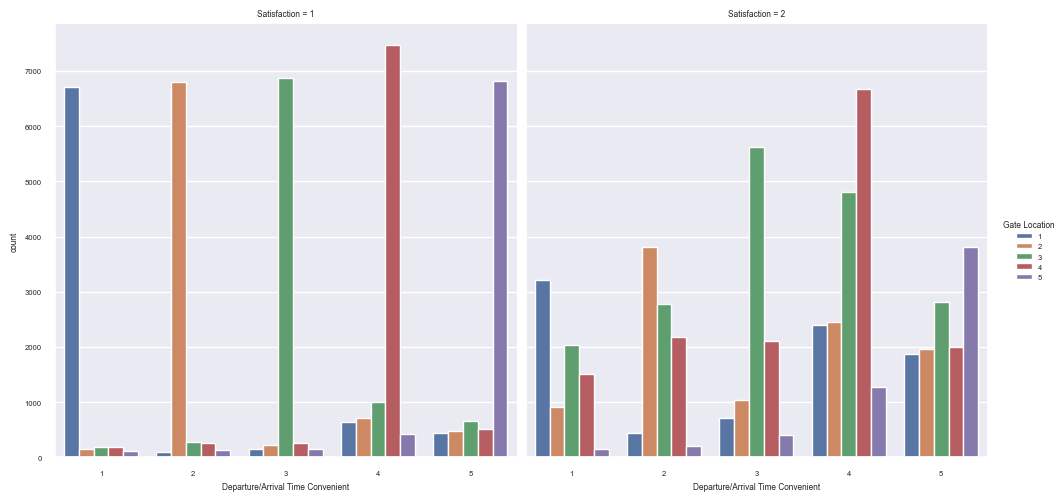

In [3018]:
sns.catplot(x = 'Departure/Arrival Time Convenient', hue = 'Gate Location', kind = 'count', col = 'Satisfaction',
             data = train)
plt.show()

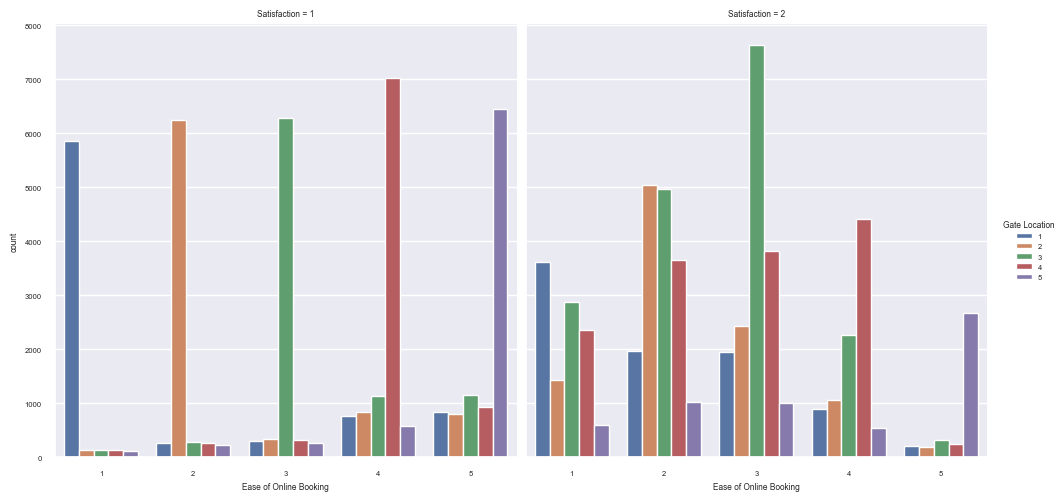

In [3019]:
sns.catplot(x = 'Ease of Online Booking', hue = 'Gate Location', kind = 'count', col = 'Satisfaction',
             data = train)
plt.show()

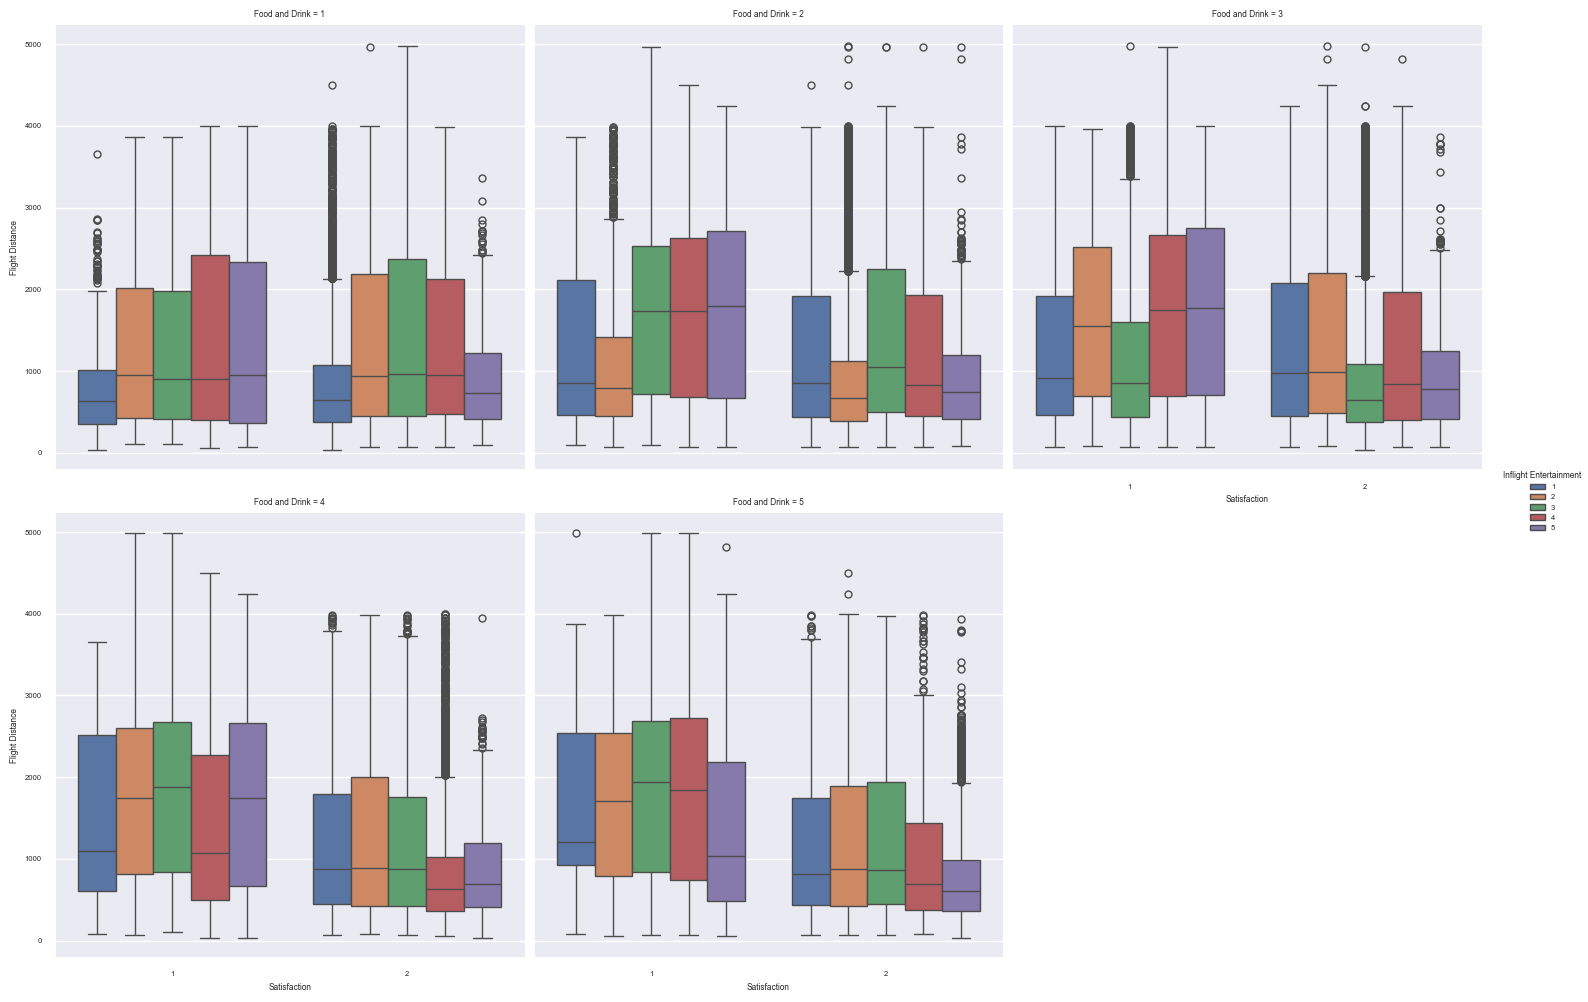

In [3020]:
sns.catplot(x = 'Satisfaction', y = 'Flight Distance', hue = 'Inflight Entertainment', kind = 'box', col = 'Food and Drink',
             col_wrap = 3, data = train)
plt.show()

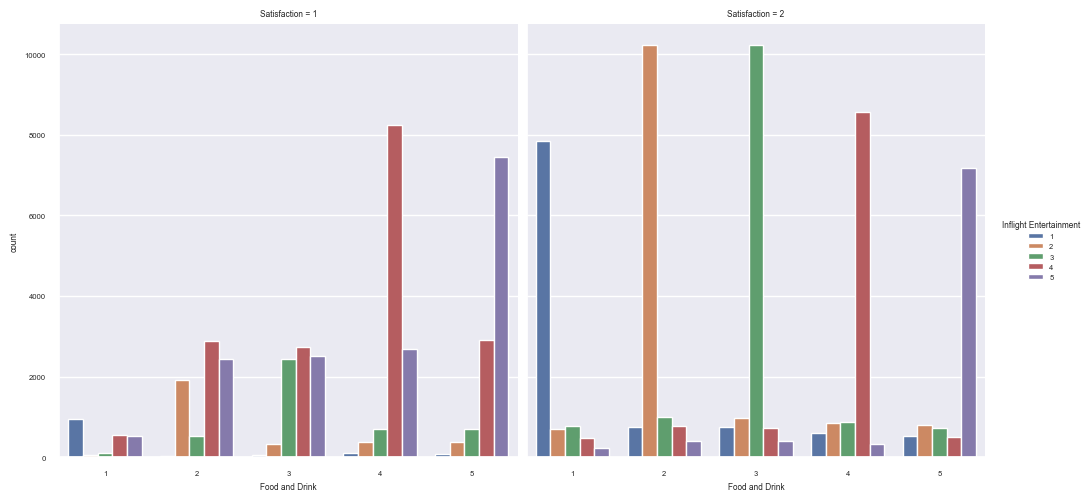

In [3021]:
sns.catplot(x = 'Food and Drink', hue = 'Inflight Entertainment', kind = 'count', col = 'Satisfaction',
             data = train)
plt.show()

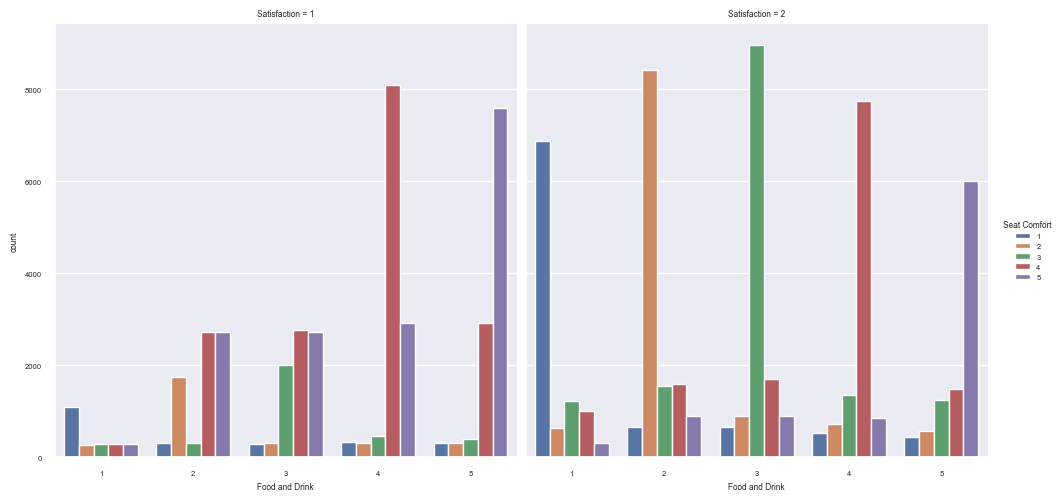

In [3022]:
sns.catplot(x = 'Food and Drink', hue = 'Seat Comfort', kind = 'count', col = 'Satisfaction',
             data = train)
plt.show()

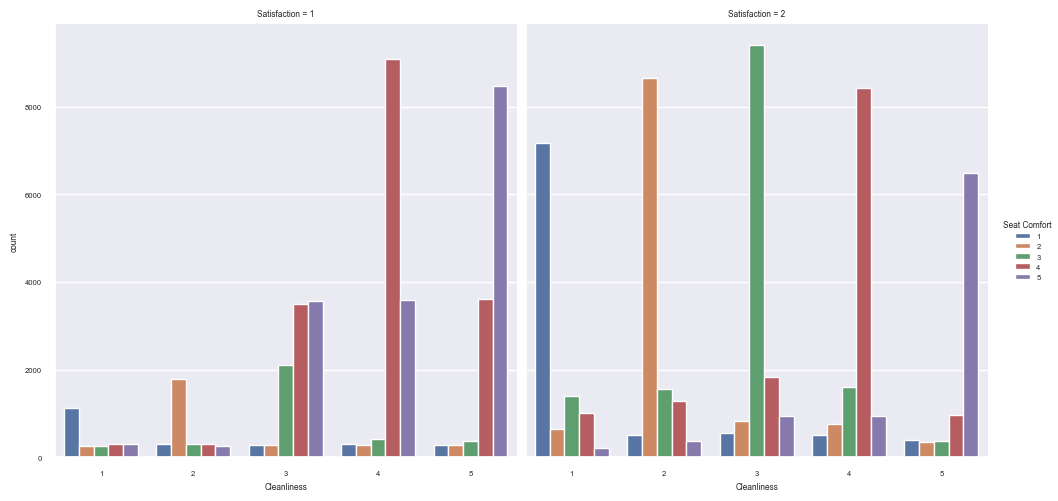

In [3023]:
sns.catplot(x = 'Cleanliness', hue = 'Seat Comfort', kind = 'count', col = 'Satisfaction',
             data = train)
plt.show()

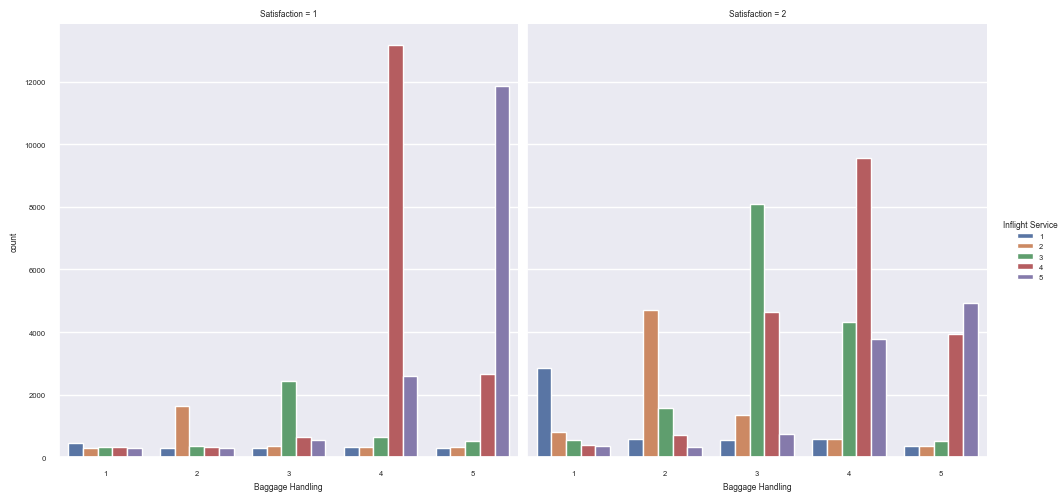

In [3024]:
sns.catplot(x = 'Baggage Handling', hue = 'Inflight Service', kind = 'count', col = 'Satisfaction',
             data = train)
plt.show()

The plots above show the relationship between a combination of correlated features in the dataset.

## Feature Engineering

### One-Hot Encoding

In [3025]:
train = pd.get_dummies(train, columns = ['Gender', 'Customer Type', 'Type of Travel'], prefix = 'Dummy', dtype = int)

train.head()

,id,Age,Class,Flight Distance,Inflight Wifi Service,Departure/Arrival Time Convenient,Ease of Online Booking,Gate Location,Food and Drink,Online Boarding,...,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,Satisfaction,Dummy_Female,Dummy_Male,Dummy_Disloyal customer,Dummy_Loyal customer,Dummy_Business travel,Dummy_Personal travel
0,70172,13,2,460,3,4,3,1,5,3,...,5,25,18.0,2,0,1,0,1,0,1
1,5047,25,3,235,3,2,3,3,1,3,...,1,1,6.0,2,0,1,1,0,1,0
2,110028,26,3,1142,2,2,2,2,5,5,...,5,0,0.0,1,1,0,0,1,1,0
3,24026,25,3,562,2,5,5,5,2,2,...,2,11,9.0,2,1,0,0,1,1,0
4,119299,61,3,214,3,3,3,3,4,5,...,3,0,0.0,1,0,1,0,1,1,0


### Transforming the Test Data Set

In [3026]:
test = pd.read_csv('test.csv')
test.head()

# Dropping unnecesarry column:
test = test.drop('Unnamed: 0', axis = 1)

# Unique column values:
len(test['id'].unique())

# Unique column values:
test['Gender'].unique()
# Change the column to categorical:
test['Gender'] = test['Gender'].astype('category')
test['Gender'].unique()

# Unique column values:
test['Customer Type'].unique()
# Format the column:
test['Customer Type'] = test['Customer Type'].str.capitalize()
test['Customer Type'].unique()

# Unique column values:
test['Age'].unique()
# Validating data:
test['Age'].min()
test['Age'].max()

# Unique column values:
test['Type of Travel'].unique()
# Capitalise the info:
test['Type of Travel'] = test['Type of Travel'].str.capitalize()
# Covert to categorical:
test['Type of Travel'] = test['Type of Travel'].astype('category')
test['Type of Travel'].unique()

# Unique column values:
test['Class'].unique()
test['Class'] = test['Class'].str.replace('Eco', '1')
test['Class'] = test['Class'].str.replace('1 Plus', '2')
test['Class'] = test['Class'].str.replace('Business', '3')
# Convert to categorical:
test['Class'] = test['Class'].astype('category')
test['Class'] = test['Class'].cat.set_categories(new_categories = ['1', '2', '3'], ordered = True)
test['Class'].unique()

# Unique column values:
test['Flight Distance'].unique()
# Validating data:
test['Flight Distance'].min()
test['Flight Distance'].max()

# Unique column values:
test['Inflight wifi service'].unique()
# Convert to categorical:
test['Inflight wifi service'] = test['Inflight wifi service'].astype('category')
test['Inflight wifi service'] = test['Inflight wifi service'].cat.set_categories(new_categories = [1, 2, 3, 4, 5], ordered = True)
test['Inflight wifi service'].unique()

# Unique column values:
test['Departure/Arrival time convenient'].unique()
# Convert to categorical:
test['Departure/Arrival time convenient'] = test['Departure/Arrival time convenient'].astype('category')
test['Departure/Arrival time convenient'] = test['Departure/Arrival time convenient'].cat.set_categories(new_categories = [1, 2, 3, 4, 5],
                                                                                                           ordered = True)
test['Departure/Arrival time convenient'].unique()

# Unique column values:
test['Ease of Online booking'].unique()
# Convert to categorical:
test['Ease of Online booking'] = test['Ease of Online booking'].astype('category')
test['Ease of Online booking'] = test['Ease of Online booking'].cat.set_categories(new_categories = [1, 2, 3, 4, 5], 
                                                                                     ordered = True)
test['Ease of Online booking'].unique()

# Unique column values:
test['Gate location'].unique()
# Convert to categorical:
test['Gate location'] = test['Gate location'].astype('category')
test['Gate location'] = test['Gate location'].cat.set_categories(new_categories = [1, 2, 3, 4, 5], ordered = True)
test['Gate location'].unique()

# Unique column values:
test['Food and drink'].unique()
# Convert to categorical:
test['Food and drink'] = test['Food and drink'].astype('category')
test['Food and drink'] = test['Food and drink'].cat.set_categories(new_categories = [1, 2, 3, 4, 5], ordered = True)
test['Food and drink'].unique()

# Unique column values:
test['Online boarding'].unique()
# Convert to categorical:
test['Online boarding'] = test['Online boarding'].astype('category')
test['Online boarding'] = test['Online boarding'].cat.set_categories(new_categories = [1, 2, 3, 4, 5], ordered = True)
test['Online boarding'].unique()

# Unique column values:
test['Seat comfort'].unique()
# Convert to categorical:
test['Seat comfort'] = test['Seat comfort'].astype('category')
test['Seat comfort'] = test['Seat comfort'].cat.set_categories(new_categories = [1, 2, 3, 4, 5], ordered = True)
test['Seat comfort'].unique()

# Unique column values:
test['Inflight entertainment'].unique()
# Convert to categorical:
test['Inflight entertainment'] = test['Inflight entertainment'].astype('category')
test['Inflight entertainment'] = test['Inflight entertainment'].cat.set_categories(new_categories = [1, 2, 3, 4, 5], ordered = True)
test['Inflight entertainment'].unique()

# Unique column values:
test['On-board service'].unique()
# Convert to categorical:
test['On-board service'] = test['On-board service'].astype('category')
test['On-board service'] = test['On-board service'].cat.set_categories(new_categories = [1, 2, 3, 4, 5], ordered = True)
test['On-board service'].unique()

# Unique column values:
test['Leg room service'].unique()
# Convert to categorical:
test['Leg room service'] = test['Leg room service'].astype('category')
test['Leg room service'] = test['Leg room service'].cat.set_categories(new_categories = [1, 2, 3, 4, 5], ordered = True)
test['Leg room service'].unique()

# Unique column values:
test['Baggage handling'].unique()
# Convert to categorical:
test['Baggage handling'] = test['Baggage handling'].astype('category')
test['Baggage handling'] = test['Baggage handling'].cat.set_categories(new_categories = [1, 2, 3, 4, 5], ordered = True)
test['Baggage handling'].unique()

# Unique column values:
test['Checkin service'].unique()
# Convert to categorical:
test['Checkin service'] = test['Checkin service'].astype('category')
test['Checkin service'] = test['Checkin service'].cat.set_categories(new_categories = [1, 2, 3, 4, 5], ordered = True)
test['Checkin service'].unique()

# Unique column values:
test['Inflight service'].unique()
# Convert to categorical:
test['Inflight service'] = test['Inflight service'].astype('category')
test['Inflight service'] = test['Inflight service'].cat.set_categories(new_categories = [1, 2, 3, 4, 5], ordered = True)
test['Inflight service'].unique()

# Unique column values:
test['Cleanliness'].unique()
# Convert to categorical:
test['Cleanliness'] = test['Cleanliness'].astype('category')
test['Cleanliness'] = test['Cleanliness'].cat.set_categories(new_categories = [1, 2, 3, 4, 5], ordered = True)
test['Cleanliness'].unique()

# Unique column values:
test['Departure Delay in Minutes'].unique()[0:100]
# Check column dtype:
test['Departure Delay in Minutes'].dtype
# Validating data:
test['Departure Delay in Minutes'].min()
test['Departure Delay in Minutes'].max()

# Unique column values:
test['Arrival Delay in Minutes'].unique()[0:100]
# Check column dtype:
test['Arrival Delay in Minutes'].dtype
# Validating data:
test['Arrival Delay in Minutes'].min()
test['Arrival Delay in Minutes'].max()

# Format column name:
test = test.rename(columns = {'satisfaction': 'Satisfaction'})
test['Satisfaction'].unique()

change = {'satisfied': 1, 'neutral or dissatisfied': 2}
test['Satisfaction'] = test['Satisfaction'].replace(change)
test['Satisfaction'] = test['Satisfaction'].astype('int')

# Convert to ordered categorical:
test['Satisfaction'] = test['Satisfaction'].astype('category')
test['Satisfaction'] = test['Satisfaction'].cat.set_categories(new_categories = [1, 2], ordered = True)

# Format column name:
test = test.rename(columns = {'Inflight wifi service': 'Inflight Wifi Service', 'Departure/Arrival time convenient': 'Departure/Arrival Time Convenient',
                                'Ease of Online booking': 'Ease of Online Booking', 'Gate location': 'Gate Location', 
                                'Food and drink': 'Food and Drink', 'Online boarding': 'Online Boarding', 'Seat comfort': 'Seat Comfort',
                                'Inflight entertainment': 'Inflight Entertainment', 'On-board service': 'On-board Service', 'Leg room service': 'Leg Room Service',
                                'Baggage handling': 'Baggage Handling', 'Checkin service': 'Checkin Service', 'Inflight service': 'Inflight Service'})

threshold = len(test)*0.05
round(threshold)

columns_to_drop = test.columns[test.isna().sum() <= threshold]
columns_to_drop

test.dropna(subset = columns_to_drop, inplace = True)
test.shape

test['Departure/Arrival Time Convenient'].mode()
test['Departure/Arrival Time Convenient'] = test['Departure/Arrival Time Convenient'].astype('string')
test['Departure/Arrival Time Convenient'].dtype
test['Departure/Arrival Time Convenient'] = test['Departure/Arrival Time Convenient'].fillna('4.0')
test['Departure/Arrival Time Convenient'].isna().sum()
test['Departure/Arrival Time Convenient'].unique()

# Convert to categorical:
test['Departure/Arrival Time Convenient'] = test['Departure/Arrival Time Convenient'].astype('category')

update_cats = {'4.0': '4', '2.0': '2', '5.0': '5', '3.0': '3', '1.0': '1'}
test['Departure/Arrival Time Convenient'] = test['Departure/Arrival Time Convenient'].replace(update_cats)

test['Departure/Arrival Time Convenient'] = test['Departure/Arrival Time Convenient'].cat.set_categories(new_categories = ['1', '2', '3', '4', '5'], ordered = True)
test['Departure/Arrival Time Convenient'].unique()

# One-Hot Encoding:
test = pd.get_dummies(test, columns = ['Gender', 'Customer Type', 'Type of Travel'], prefix = 'Dummy', dtype = int)

/var/folders/1z/2qtxqpxj07g0pvc7h463fm_w0000gn/T/ipykernel_38175/1406128203.py:173: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test['Satisfaction'] = test['Satisfaction'].replace(change)
/var/folders/1z/2qtxqpxj07g0pvc7h463fm_w0000gn/T/ipykernel_38175/1406128203.py:207: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  test['Departure/Arrival Time Convenient'] = test['Departure/Arrival Time Convenient'].replace(update_cats)


In [3030]:
# Saving the first preprocessed dataset to csv:
train.to_csv('train_preprocessed_1.csv', index = False)
test.to_csv('test_preprocessed_1.csv', index = False)

## Classification

In [3027]:
# Splitting the data into train and test sets:
X = train.drop(columns = 'Satisfaction', axis = 1)
y = train['Satisfaction']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = 0.3)

# Scaling the data:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Four models are used in this classification task. Kfold cross validation is used with 6 splits. Model comparison is depicted using boxplots below.

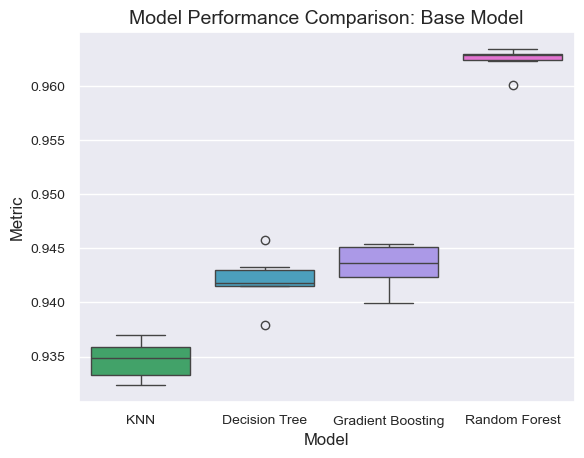

In [3028]:
# Defining and implementing the four models
models = {'KNN': KNeighborsClassifier(),
          'Decision Tree': DecisionTreeClassifier(),
          'Gradient Boosting': GradientBoostingClassifier(),
          'Random Forest': RandomForestClassifier()}

# Kfold cross-validation is used to ensure reproducibility of results:
results = []

for name, model in models.items():
    kf = KFold(n_splits=6, random_state=42, shuffle=True)
    cv_results = cross_val_score(model, X_train_scaled, y_train, cv=kf)
    for result in cv_results:
        results.append([name, result])

# Convert results into a DataFrame
bp_data = pd.DataFrame(results, columns=['Model', 'Metric'])

sns.set_style('darkgrid')
husl_palette = sns.color_palette("husl", n_colors=8)
ax = sns.boxplot(x='Model', y='Metric', hue='Model', data=bp_data, 
            palette=[husl_palette[3], husl_palette[5], husl_palette[6], husl_palette[7]])

# Customizing the plot
ax.set_title('Model Performance Comparison: Base Model', fontsize = 14)  # Set title font size
ax.set_xlabel('Model', fontsize = 12)  # Set x-axis label with font size
ax.set_ylabel('Metric', fontsize = 12)  # Set y-axis label with font size
ax.tick_params(axis='both', labelsize = 10)

plt.show()

knn Test Set Accuracy: 0.9381279924472318
decision_tree Test Set Accuracy: 0.940454514802077
gradient_boosting Test Set Accuracy: 0.9457481961022322
random_forest Test Set Accuracy: 0.9635511497740913


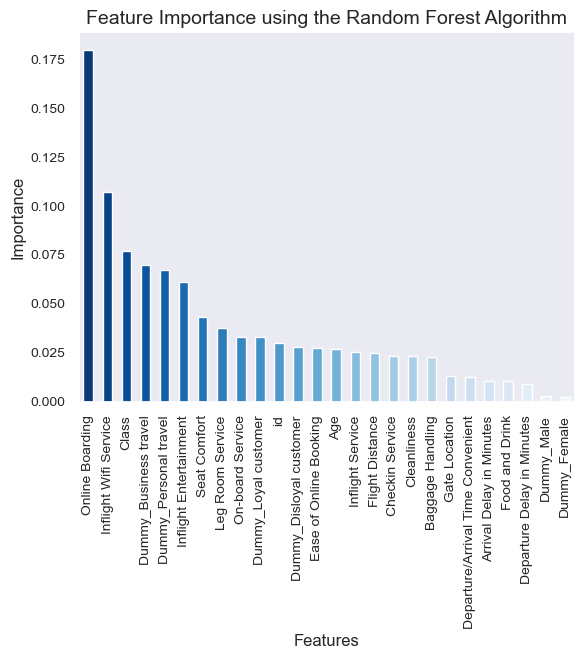

In [3037]:
# Renaming models to be saved
models = {'knn': KNeighborsClassifier(),
          'decision_tree': DecisionTreeClassifier(),
          'gradient_boosting': GradientBoostingClassifier(),
          'random_forest': RandomForestClassifier()}

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    test_score = model.score(X_test_scaled, y_test)
    print('{} Test Set Accuracy: {}'.format(name, test_score))
    # save each model as a pickle file
    model_pkl_file = '{}.pkl'.format(name)  
    with open(model_pkl_file, 'wb') as file:  
        pickle.dump(model, file)
    
    # Setting the style to dark
    sns.set_style('dark')

    if name == 'random_forest':
        # Feature importance for Random Forest
        importance = pd.Series(model.feature_importances_, index=X_train.columns)
        
        # Setting the Seaborn "mako" palette for the number of features
        colors = list(reversed(sns.color_palette("Blues", len(importance))))
    
        # Plotting the feature importance using a bar plot
        ax = importance.sort_values(ascending=False).plot(kind='bar', color = colors)
        
        # Customize the labels and title
        ax.set_xlabel('Features', fontsize = 12)
        ax.set_ylabel('Importance', fontsize = 12)
        ax.set_title('Feature Importance using the Random Forest Algorithm', fontsize = 14)
        ax.tick_params(axis='both', labelsize = 10)
        
        # Display the plot
        plt.show()


Unexplectedly, the random forest seems to perform singificantly better than the other models. The random forest algorithm has been used to extract feature importance; it can be seen that `Online Boarding` is by far the most important feature affecting passenger saitsfaction. The second and thrid most important features are `Inflight Wifi Service` and `Class`, respectively. 

In [3042]:
# load model from pickle file
with open(model_pkl_file, 'rb') as file:  
    model = pickle.load(file)

# evaluate model 
y_predict = model.predict(X_test_scaled)

# check results
print(classification_report(y_test, y_predict)) 

              precision    recall  f1-score   support

           1       0.97      0.94      0.96     12482
           2       0.96      0.98      0.97     17176

    accuracy                           0.96     29658
   macro avg       0.97      0.96      0.96     29658
weighted avg       0.96      0.96      0.96     29658



## Improving the Machine Learning Model

#### Feature Interaction

Here, an attempt to improve the models' performance is done through the incorporation of feature interactions. The first feature to be included will be `Total Delay`, which is simply the combination of departure delays and arrival delays. 

In [2749]:
# Combining the two types of delays:
train['Total Delay'] = train['Departure Delay in Minutes'] + train['Arrival Delay in Minutes']

# Splitting `Total Delay` into 3 categories:
no_delay = train['Total Delay'] <= 5
short_delay = np.logical_and(train['Total Delay'] > 5, train['Total Delay'] <= 30)
long_delay = train['Total Delay'] > 30

# Setting the conditions and choices:
conditions = [no_delay, short_delay, long_delay]
choices = ['No Delay', 'Short Delay', 'Long Delay']

# Categorising:
train['Delay Category'] = np.select(conditions, choices, default='Unknown')

# Setting the new feature as categorical:
train['Delay Category'] = train['Delay Category'].astype('category')
train['Delay Category'] = train['Delay Category'].cat.set_categories(new_categories = ['No Delay', 'Short Delay', 'Long Delay'], ordered = True)



The next feature to be created is called the `Age Group` feature, where passenger ages are binned into groups. 

In [2750]:
# Defining the categorical age bins:
child = train['Age'] < 18
young_adult = (train['Age'] >= 18) & (train['Age'] < 25)
adult = (train['Age'] >= 25) & (train['Age'] < 45)
middle_age = (train['Age'] >= 45) & (train['Age'] < 60)
senior = train['Age'] >= 60

# Setting the condition and choices:
conditions = [child, young_adult, adult, middle_age, senior]
choices = ['Child', 'Young Adult', 'Adult', 'Middle Age', 'Senior']

# Categorising:
train['Age Group'] = np.select(conditions, choices, default='Unknown')

# Setting the new feature as categorical:
train['Age Group'] = train['Age Group'].astype('category')
train['Age Group'] = train['Age Group'].cat.set_categories(new_categories = ['Child', 'Young Adult', 'Adult', 'Middle Age', 'Senior'], ordered = True)

The new variables have to be one-hot encoded before proceding to model implementation.

In [2751]:
# One-Hot Encoding:
train = pd.get_dummies(train, columns = ['Delay Category', 'Age Group'], prefix = 'Dummy', dtype = int)

Next, the same process is repeated for the test data set.

In [2753]:
# Combining the two types of delays:
test['Total Delay'] = test['Departure Delay in Minutes'] + test['Arrival Delay in Minutes']

# Splitting `Total Delay` into 3 categories:
no_delay = test['Total Delay'] <= 5
short_delay = np.logical_and(test['Total Delay'] > 5, test['Total Delay'] <= 30)
long_delay = test['Total Delay'] > 30

# Setting the conditions and choices:
conditions = [no_delay, short_delay, long_delay]
choices = ['No Delay', 'Short Delay', 'Long Delay']

# Categorising:
test['Delay Category'] = np.select(conditions, choices, default='Unknown')

# Setting the new feature as categorical:
test['Delay Category'] = test['Delay Category'].astype('category')
test['Delay Category'] = test['Delay Category'].cat.set_categories(new_categories = ['No Delay', 'Short Delay', 'Long Delay'], ordered = True)

# Defining the categorical age bins:
child = test['Age'] < 18
young_adult = (test['Age'] >= 18) & (test['Age'] < 25)
adult = (test['Age'] >= 25) & (test['Age'] < 45)
middle_age = (test['Age'] >= 45) & (test['Age'] < 60)
senior = test['Age'] >= 60

# Setting the condition and choices:
conditions = [child, young_adult, adult, middle_age, senior]
choices = ['Child', 'Young Adult', 'Adult', 'Middle Age', 'Senior']

# Categorising:
test['Age Group'] = np.select(conditions, choices, default='Unknown')

# Setting the new feature as categorical:
test['Age Group'] = test['Age Group'].astype('category')
test['Age Group'] = test['Age Group'].cat.set_categories(new_categories = ['Child', 'Young Adult', 'Adult', 'Middle Age', 'Senior'], ordered = True)

# One-Hot Encoding:
test = pd.get_dummies(test, columns = ['Delay Category', 'Age Group'], prefix = 'Dummy', dtype = int)

In [2755]:
# Splitting the data into train and test sets:
X = train.drop(columns = 'Satisfaction', axis = 1)
y = train['Satisfaction']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = 0.3)

# Scaling the data:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

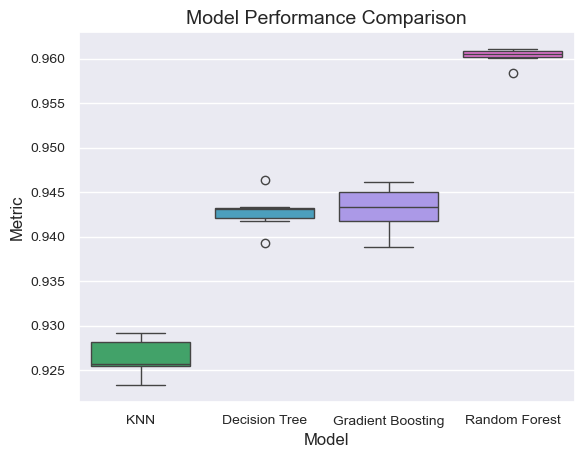

In [2756]:
# Defining and implementing the four models
models = {'KNN': KNeighborsClassifier(),
          'Decision Tree': DecisionTreeClassifier(),
          'Gradient Boosting': GradientBoostingClassifier(),
          'Random Forest': RandomForestClassifier()}

# Kfold cross-validation is used to ensure reproducibility of results:
results = []

for name, model in models.items():
    kf = KFold(n_splits=6, random_state=42, shuffle=True)
    cv_results = cross_val_score(model, X_train_scaled, y_train, cv=kf)
    for result in cv_results:
        results.append([name, result])

# Convert results into a DataFrame
bp_data = pd.DataFrame(results, columns=['Model', 'Metric'])

sns.set_style('darkgrid')
husl_palette = sns.color_palette("husl", n_colors=8)
ax = sns.boxplot(x='Model', y='Metric', hue='Model', data=bp_data, 
            palette=[husl_palette[3], husl_palette[5], husl_palette[6], husl_palette[7]])

# Customizing the plot
ax.set_title('Model Performance Comparison: Feature Interaction', fontsize = 14)  # Set title font size
ax.set_xlabel('Model', fontsize = 12)  # Set x-axis label with font size
ax.set_ylabel('Metric', fontsize = 12)  # Set y-axis label with font size
ax.tick_params(axis='both', labelsize = 10)

plt.show()

In [2757]:
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    test_score = model.score(X_test_scaled, y_test)
    print('{} Test Set Accuracy: {}'.format(name, test_score))

KNN Test Set Accuracy: 0.9281475487220986
Decision Tree Test Set Accuracy: 0.9423427068581833
Gradient Boosting Test Set Accuracy: 0.9458830669633825
Random Forest Test Set Accuracy: 0.962101288016724


The impact of adding this feature is not very strong. The Decidion Tree model and Gradient Boosting had slight improvements, the other two models performed worse. 

#### Aggregating Satisfaction Level

The features added in the previous section will be removed and an aggregate satisfaction level feature will be added to see its impact in comparison to the original model.

In [2898]:
train['Overall Service Satisfaction'] = np.mean([train['Departure/Arrival Time Convenient'].astype('int'), train['Ease of Online Booking'].astype('int'), train['Gate Location'].astype('int'),
                                             train['Food and Drink'].astype('int'), train['Online Boarding'].astype('int'), train['Seat Comfort'].astype('int'), train['Inflight Entertainment'].astype('int'),
                                             train['On-board Service'].astype('int'), train['Leg Room Service'].astype('int'), train['Baggage Handling'].astype('int'), train['Checkin Service'].astype('int')], axis = 0).round(2)

In [2899]:
test['Overall Service Satisfaction'] = np.mean([test['Departure/Arrival Time Convenient'].astype('int'), test['Ease of Online Booking'].astype('int'), test['Gate Location'].astype('int'),
                                             test['Food and Drink'].astype('int'), test['Online Boarding'].astype('int'), test['Seat Comfort'].astype('int'), test['Inflight Entertainment'].astype('int'),
                                             test['On-board Service'].astype('int'), test['Leg Room Service'].astype('int'), test['Baggage Handling'].astype('int'), test['Checkin Service'].astype('int')], axis = 0).round(2)

In [2903]:
# Splitting the data into train and test sets:
X = train.drop(columns = 'Satisfaction', axis = 1)
y = train['Satisfaction']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = 0.3)

# Scaling the data:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

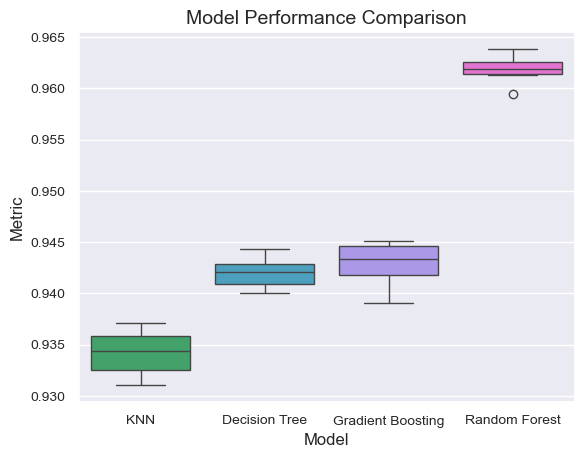

In [2821]:
# Defining and implementing the four models
models = {'KNN': KNeighborsClassifier(),
          'Decision Tree': DecisionTreeClassifier(),
          'Gradient Boosting': GradientBoostingClassifier(),
          'Random Forest': RandomForestClassifier()}

# Kfold cross-validation is used to ensure reproducibility of results:
results = []

for name, model in models.items():
    kf = KFold(n_splits=6, random_state=42, shuffle=True)
    cv_results = cross_val_score(model, X_train_scaled, y_train, cv=kf)
    for result in cv_results:
        results.append([name, result])

# Convert results into a DataFrame
bp_data = pd.DataFrame(results, columns=['Model', 'Metric'])

sns.set_style('darkgrid')
husl_palette = sns.color_palette("husl", n_colors=8)
ax = sns.boxplot(x='Model', y='Metric', hue='Model', data=bp_data, 
            palette=[husl_palette[3], husl_palette[5], husl_palette[6], husl_palette[7]])

# Customizing the plot
ax.set_title('Model Performance Comparison: Aggregated Satisfaction Level', fontsize = 14)  # Set title font size
ax.set_xlabel('Model', fontsize = 12)  # Set x-axis label with font size
ax.set_ylabel('Metric', fontsize = 12)  # Set y-axis label with font size
ax.tick_params(axis='both', labelsize = 10)

plt.show()

In [2822]:
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    test_score = model.score(X_test_scaled, y_test)
    print('{} Test Set Accuracy: {}'.format(name, test_score))

KNN Test Set Accuracy: 0.9381279924472318
Decision Tree Test Set Accuracy: 0.9411963045384045
Gradient Boosting Test Set Accuracy: 0.9450401240811923
Random Forest Test Set Accuracy: 0.9635174320588037


Again, this additional feature improved the results for some of the models, but not for others. This might not be trasnferable to a new data set, that is it might be the result of chance. 

#### Outlier Detection

Keeping the results from the previous section.

In [2823]:
# Defining the quantiles:
q1 = np.quantile(train['Flight Distance'], 0.25)
q3 = np.quantile(train['Flight Distance'], 0.75)

# Defining IQR:
iqr = q3 - q1

# Establishing the lower and upper boundaries:
lower_f = q1 - 1.5*iqr
upper_f = q3 + 1.5*iqr

# Establishing the outliers:
outliers_f = train[(train['Flight Distance'] < lower_f) | (train['Flight Distance'] > upper_f)]

In [2824]:
# Defining the quantiles:
q1 = np.quantile(train['Departure Delay in Minutes'], 0.25)
q3 = np.quantile(train['Departure Delay in Minutes'], 0.75)

# Defining IQR:
iqr = q3 - q1

# Establishing the lower and upper boundaries:
lower_d = q1 - 1.5*iqr
upper_d = q3 + 1.5*iqr

# Establishing the outliers:
outliers_d = train[(train['Departure Delay in Minutes'] < lower_d) | (train['Departure Delay in Minutes'] > upper_d)]

In [2825]:
# Defining the quantiles:
q1 = np.quantile(train['Arrival Delay in Minutes'], 0.25)
q3 = np.quantile(train['Arrival Delay in Minutes'], 0.75)

# Defining IQR:
iqr = q3 - q1

# Establishing the lower and upper boundaries:
lower_a = q1 - 1.5*iqr
upper_a = q3 + 1.5*iqr

# Establishing the outliers:
outliers_a = train[(train['Arrival Delay in Minutes'] < lower_a) | (train['Arrival Delay in Minutes'] > upper_a)]

In [2826]:
# Removing the outliers:
train_no_outliers = train[(train['Flight Distance'] > lower_f) & (train['Flight Distance'] < upper_f)&
                          (train['Departure Delay in Minutes'] > lower_d) & (train['Departure Delay in Minutes'] < upper_d) &
                          (train['Arrival Delay in Minutes'] > lower_a) & (train['Arrival Delay in Minutes'] < upper_a)]

Repeating the same for the test set:

In [2827]:
# Defining the quantiles:
q1 = np.quantile(test['Flight Distance'], 0.25)
q3 = np.quantile(test['Flight Distance'], 0.75)

# Defining IQR:
iqr = q3 - q1

# Establishing the lower and upper boundaries:
lower_f = q1 - 1.5*iqr
upper_f = q3 + 1.5*iqr

# Establishing the outliers:
outliers_f = test[(test['Flight Distance'] < lower_f) | (test['Flight Distance'] > upper_f)]

# Defining the quantiles:
q1 = np.quantile(test['Departure Delay in Minutes'], 0.25)
q3 = np.quantile(test['Departure Delay in Minutes'], 0.75)

# Defining IQR:
iqr = q3 - q1

# Establishing the lower and upper boundaries:
lower_d = q1 - 1.5*iqr
upper_d = q3 + 1.5*iqr

# Establishing the outliers:
outliers_d = test[(test['Departure Delay in Minutes'] < lower_d) | (test['Departure Delay in Minutes'] > upper_d)]

# Defining the quantiles:
q1 = np.quantile(test['Arrival Delay in Minutes'], 0.25)
q3 = np.quantile(test['Arrival Delay in Minutes'], 0.75)

# Defining IQR:
iqr = q3 - q1

# Establishing the lower and upper boundaries:
lower_a = q1 - 1.5*iqr
upper_a = q3 + 1.5*iqr

# Establishing the outliers:
outliers_a = test[(test['Arrival Delay in Minutes'] < lower_a) | (test['Arrival Delay in Minutes'] > upper_a)]

# Removing the outliers:
test_no_outliers = test[(test['Flight Distance'] > lower_f) & (test['Flight Distance'] < upper_f)&
                          (test['Departure Delay in Minutes'] > lower_d) & (test['Departure Delay in Minutes'] < upper_d) &
                          (test['Arrival Delay in Minutes'] > lower_a) & (test['Arrival Delay in Minutes'] < upper_a)]

In [2828]:
# Splitting the data into train and test sets:
X = train_no_outliers.drop(columns = 'Satisfaction', axis = 1)
y = train_no_outliers['Satisfaction']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = 0.3)

# Scaling the data:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

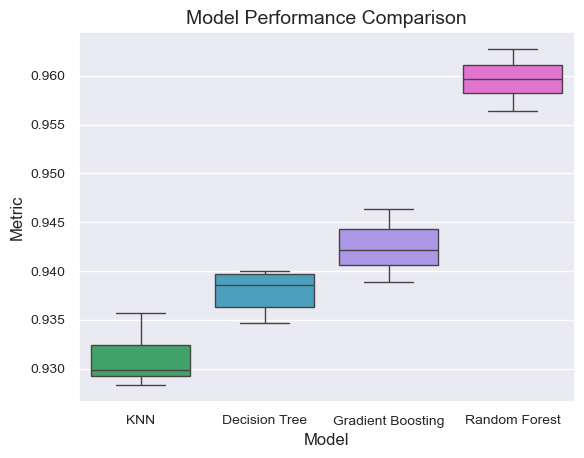

In [2829]:
# Defining and implementing the four models
models = {'KNN': KNeighborsClassifier(),
          'Decision Tree': DecisionTreeClassifier(),
          'Gradient Boosting': GradientBoostingClassifier(),
          'Random Forest': RandomForestClassifier()}

# Kfold cross-validation is used to ensure reproducibility of results:
results = []

for name, model in models.items():
    kf = KFold(n_splits=6, random_state=42, shuffle=True)
    cv_results = cross_val_score(model, X_train_scaled, y_train, cv=kf)
    for result in cv_results:
        results.append([name, result])

# Convert results into a DataFrame
bp_data = pd.DataFrame(results, columns=['Model', 'Metric'])

sns.set_style('darkgrid')
husl_palette = sns.color_palette("husl", n_colors=8)
ax = sns.boxplot(x='Model', y='Metric', hue='Model', data=bp_data, 
            palette=[husl_palette[3], husl_palette[5], husl_palette[6], husl_palette[7]])

# Customizing the plot
ax.set_title('Model Performance Comparison: No Outliers', fontsize = 14)  # Set title font size
ax.set_xlabel('Model', fontsize = 12)  # Set x-axis label with font size
ax.set_ylabel('Metric', fontsize = 12)  # Set y-axis label with font size
ax.tick_params(axis='both', labelsize = 10)

plt.show()

In [2830]:
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    test_score = model.score(X_test_scaled, y_test)
    print('{} Test Set Accuracy: {}'.format(name, test_score))

KNN Test Set Accuracy: 0.9314944047569889
Decision Tree Test Set Accuracy: 0.9407853986868728
Gradient Boosting Test Set Accuracy: 0.9414460915885535
Random Forest Test Set Accuracy: 0.9583763471941198


The removal of the outliers has resulted in poorer results for all models. This suggests that the 'outliers' do contain useful information and it is best to keep them in the model. 

# Hyperparameter Tuning for Random Forest

Keeping Aggregating Satisfaction Levels

In [2905]:
# Splitting the data into train and test sets:
X = train.drop(columns = 'Satisfaction', axis = 1)
y = train['Satisfaction']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = 0.3)

# Scaling the data:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [2911]:
kf = KFold(n_splits=6, random_state=42, shuffle=True)

parameter_grid = {'n_estimators': [50, 100, 150, 200, 250],
                  'criterion': ['gini', 'entropy', 'log_loss'],
                  'max_depth': [1, 2, 3, 4, 5],
                  'min_samples_leaf': [1, 2, 3],
                  'min_samples_split': [2, 3, 4, 5],
                  'max_features': ['sqrt', 'log2', None]}

rf = RandomForestClassifier(random_state = 42)

rf_cv = RandomizedSearchCV(rf, parameter_grid, cv = kf, n_iter = 10)

rf_cv.fit(X_train_scaled, y_train)

print(rf_cv.best_params_)
print(rf_cv.best_score_)


{'n_estimators': 200, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 4, 'criterion': 'entropy'}
0.9190630577836938


In [2924]:
parameter_grid = {'n_estimators': [75, 100, 125, 150, 175, 200, 225, 250],
                  'min_samples_leaf': [1, 2, 3],
                  'min_samples_split': [2, 3, 4, 5]}

rf = RandomForestClassifier()

rf_cv = GridSearchCV(rf, parameter_grid, cv = kf)

rf_cv.fit(X_train_scaled, y_train)

print(rf_cv.best_params_)
print(rf_cv.best_score_)

{'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
0.9625733464093028


In [2928]:
# Saving the tuned Random Forest model as a pickle file
rf_cv_file = "rf_cv_model.pkl"  

with open(rf_cv_file, 'wb') as file:  
    pickle.dump(model, file)

In [2921]:
rf = RandomForestClassifier(min_samples_leaf = 1, min_samples_split = 3, n_estimators = 225)
rf.fit(X_train_scaled, y_train)
print(rf.score(X_test_scaled, y_test))

0.9640569155034054


In [2927]:
rf = RandomForestClassifier(min_samples_leaf = 1, min_samples_split = 5, n_estimators = 200)
rf.fit(X_train_scaled, y_train)
print(rf.score(X_test_scaled, y_test))

0.9634837143435161
